<a href="https://colab.research.google.com/github/mari-linhares/tensorflow-maml/blob/master/maml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAML reimplementation using TensorFlow 2.0

Reproduction of MAML using TensorFlow 2.0.

This  is highly influenced by the pytorch reproduction by Adrien Lucas Effot: [Paper repro: Deep Metalearning using “MAML” and “Reptile”](https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0)

Github: [https://github.com/mari-linhares/tensorflow-maml](https://github.com/mari-linhares/tensorflow-maml)

Twitter: [@hereismari](https://twitter.com/hereismari)

## MAML paper

https://arxiv.org/abs/1703.03400

**Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**
*Chelsea Finn, Pieter Abbeel, Sergey Levine*

> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

---

![image.png](https://cdn-images-1.medium.com/max/1600/1*EUt0H5AOEFkERg-OzfCC7A.png)


### TensorFlow installation

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-alpha0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-alpha0


### Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend


# Other dependencies
import random
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

# Reproduction
np.random.seed(333)


print('Python version: ', sys.version)
print('TensorFlow version: ', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('GPU found at: {}'.format(device_name))

Python version:  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
TensorFlow version:  2.15.0


SystemError: GPU device not found

## Section 5.1 Evaluating MAML on regression

> *We start with a simple regression problem that illustrates
the basic principles of MAML. Each task involves regressing
from the input to the output of a sine wave, where the
amplitude and phase of the sinusoid are varied between
tasks. Thus, p(T ) is continuous, where the amplitude
varies within [0.1, 5.0] and the phase varies within [0, π],
and the input and output both have a dimensionality of 1.
During training and testing, datapoints x are sampled uniformly
from [−5.0, 5.0].*

![]()

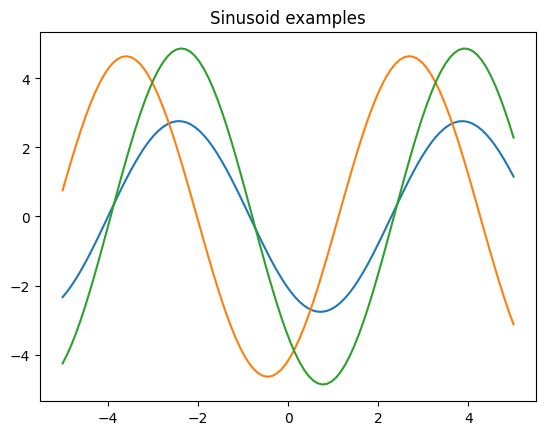

In [2]:
class SinusoidGenerator():
    '''
        Sinusoid Generator.

        p(T) is continuous, where the amplitude varies within [0.1, 5.0]
        and the phase varies within [0, π].

        This abstraction is the basically the same defined at:
        https://towardsdatascience.com/paper-repro-deep-metalearning-using-maml-and-reptile-fd1df1cc81b0
    '''
    def __init__(self, K=10, amplitude=None, phase=None):
        '''
        Args:
            K: batch size. Number of values sampled at every batch.
            amplitude: Sine wave amplitude. If None is uniformly sampled from
                the [0.1, 5.0] interval.
            pahse: Sine wave phase. If None is uniformly sampled from the [0, π]
                interval.
        '''
        self.K = K
        self.amplitude = amplitude if amplitude else np.random.uniform(0.1, 5.0)
        self.phase = phase if amplitude else np.random.uniform(0, np.pi)
        self.sampled_points = None
        self.x = self._sample_x()

    def _sample_x(self):
        return np.random.uniform(-5, 5, self.K)

    def f(self, x):
        '''Sinewave function.'''
        return self.amplitude * np.sin(x - self.phase)

    def batch(self, x = None, force_new=False):
        '''Returns a batch of size K.

        It also changes the shape of `x` to add a batch dimension to it.

        Args:
            x: Batch data, if given `y` is generated based on this data.
                Usually it is None. If None `self.x` is used.
            force_new: Instead of using `x` argument the batch data is
                uniformly sampled.

        '''
        if x is None:
            if force_new:
                x = self._sample_x()
            else:
                x = self.x
        y = self.f(x)
        return x[:, None], y[:, None]

    def equally_spaced_samples(self, K=None):
        '''Returns `K` equally spaced samples.'''
        if K is None:
            K = self.K
        return self.batch(x=np.linspace(-5, 5, K))


def plot(data, *args, **kwargs):
    '''Plot helper.'''
    x, y = data
    return plt.plot(x, y, *args, **kwargs)


for _ in range(3):
    plt.title('Sinusoid examples')
    plot(SinusoidGenerator(K=100).equally_spaced_samples())
plt.show()

### Generate sinusoid datasets


In [3]:
def generate_dataset(K, train_size=20000, test_size=10):
    '''Generate train and test dataset.

    A dataset is composed of SinusoidGenerators that are able to provide
    a batch (`K`) elements at a time.
    '''
    def _generate_dataset(size):
        return [SinusoidGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size), _generate_dataset(test_size)

train_ds, test_ds = generate_dataset(K=10)

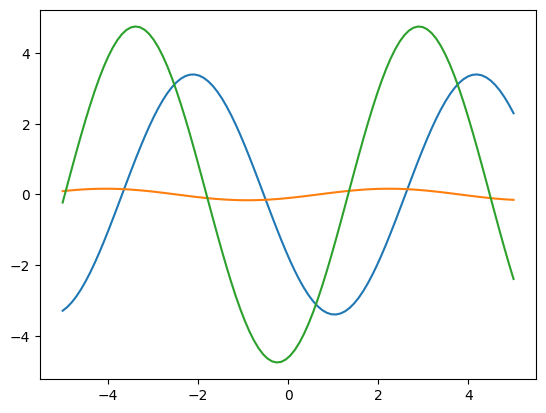

In [ ]:
plot(train_ds[0].equally_spaced_samples(100))
plot(train_ds[1].equally_spaced_samples(100))
plot(train_ds[2].equally_spaced_samples(100))
plt.show()

### Training a regular Neural Network

We're training a Neural Network for given a batch of size *K* of randomly sampled values (*x*) predict *f(x)* where f is a sine wave function with amplitude randomly sampled within [0.1, 5.0] and the phase randomly sampled within [0, π].

#### Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [4]:
class SineModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)

    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

#### Training implementation

In [5]:
def loss_function(pred_y, y):
  return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)


def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mse = loss_fn(y, logits)
    return mse, logits


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))


def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss


def train_model(dataset, epochs=1, lr=0.001, log_steps=1000):
    model = SineModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, sinusoid_generator in enumerate(dataset):
            x, y = sinusoid_generator.batch()
            loss = train_batch(x, y, model, optimizer)
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)

            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.title('Loss Vs Time steps')
        plt.show()
    return model

#### Train Model

Step 1000: loss = 3.718918863430471, Time to run 1000 steps = 12.47 seconds
Step 2000: loss = 3.5690590626128285, Time to run 1000 steps = 12.63 seconds
Step 3000: loss = 3.4762967789360943, Time to run 1000 steps = 12.70 seconds
Step 4000: loss = 3.370881589986493, Time to run 1000 steps = 13.14 seconds
Step 5000: loss = 3.317985698199728, Time to run 1000 steps = 12.86 seconds
Step 6000: loss = 3.275759400920205, Time to run 1000 steps = 12.71 seconds
Step 7000: loss = 3.2308529149327274, Time to run 1000 steps = 12.85 seconds
Step 8000: loss = 3.2087709528084627, Time to run 1000 steps = 12.84 seconds
Step 9000: loss = 3.1907728752576463, Time to run 1000 steps = 12.69 seconds
Step 10000: loss = 3.186509555351141, Time to run 1000 steps = 12.86 seconds
Step 11000: loss = 3.172652435132343, Time to run 1000 steps = 12.90 seconds
Step 12000: loss = 3.1667601069094675, Time to run 1000 steps = 12.47 seconds
Step 13000: loss = 3.149206087559992, Time to run 1000 steps = 12.66 seconds
St

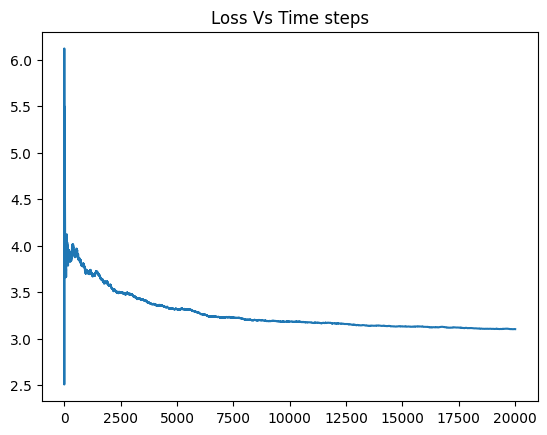

In [ ]:
neural_net = train_model(train_ds)

A neural network trained for this task, should converge to the average of the sinusoids curves.

In [ ]:
def plot_model_comparison_to_average(model, ds, model_name='neural network', K=10):
    '''Compare model to average.

    Computes mean of training sine waves actual `y` and compare to
    the model's prediction to a new sine wave, the intuition is that
    these two plots should be similar.
    '''
    sinu_generator = SinusoidGenerator(K=K)

    # calculate average prediction
    avg_pred = []
    for i, sinusoid_generator in enumerate(ds):
        x, y = sinusoid_generator.equally_spaced_samples()
        avg_pred.append(y)

    x, _ = sinu_generator.equally_spaced_samples()
    avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0), '--')

    # calculate model prediction
    model_pred = model.forward(tf.convert_to_tensor(x))
    model_plot, = plt.plot(x, model_pred.numpy())

    # plot
    plt.legend([avg_plot, model_plot], ['Average', model_name])
    plt.show()

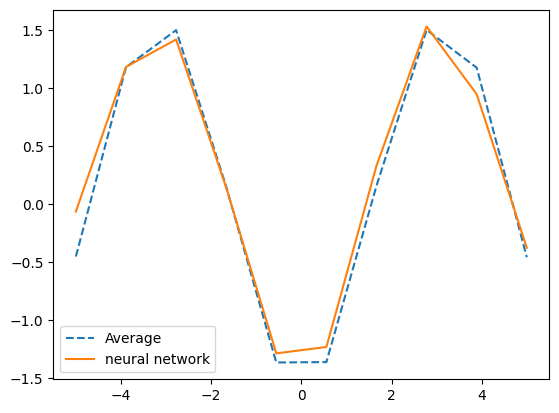

In [ ]:
plot_model_comparison_to_average(neural_net, train_ds)

### Transfer learning?

Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.

In [ ]:
def copy_model(model, x):
    '''Copy model weights to a new model.

    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = SineModel()

    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))

    copied_model.set_weights(model.get_weights())
    return copied_model


def eval_sine_test(model, optimizer, x, y, x_test, y_test, num_steps=(0, 1, 10)):
    '''Evaluate how the model fits to the curve training for `fits` steps.

    Args:
        model: Model evaluated.
        optimizer: Optimizer to be for training.
        x: Data used for training.
        y: Targets used for training.
        x_test: Data used for evaluation.
        y_test: Targets used for evaluation.
        num_steps: Number of steps to log.
    '''
    fit_res = []

    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test))

    # If 0 in fits we log the loss before any training
    if 0 in num_steps:
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits, loss))

    for step in range(1, np.max(num_steps) + 1):
        train_batch(x, y, model, optimizer)
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append(
                (
                    step,
                    logits,
                    loss
                )
            )
    return fit_res


def eval_sinewave_for_test(model, sinusoid_generator=None, num_steps=(0, 1, 10), lr=0.01, plot=True):
    '''Evaluates how the sinewave addapts at dataset.

    The idea is to use the pretrained model as a weight initializer and
    try to fit the model on this new dataset.

    Args:
        model: Already trained model.
        sinusoid_generator: A sinusoidGenerator instance.
        num_steps: Number of training steps to be logged.
        lr: Learning rate used for training on the test data.
        plot: If plot is True than it plots how the curves are fitted along
            `num_steps`.

    Returns:
        The fit results. A list containing the loss, logits and step. For
        every step at `num_steps`.
    '''

    if sinusoid_generator is None:
        sinusoid_generator = SinusoidGenerator(K=10)

    # generate equally spaced samples for ploting
    x_test, y_test = sinusoid_generator.equally_spaced_samples(100)

    # batch used for training
    x, y = sinusoid_generator.batch()

    # copy model so we can use the same model multiple times
    copied_model = copy_model(model, x)

    # use SGD for this part of training as described in the paper
    optimizer = keras.optimizers.SGD(learning_rate=lr)

    # run training and log fit results
    fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)

    # plot
    train, = plt.plot(x, y, '^')
    ground_truth, = plt.plot(x_test, y_test)
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    for n, res, loss in fit_res:
        cur, = plt.plot(x_test, res[:, 0], '--')
        plots.append(cur)
        legend.append(f'After {n} Steps')
    plt.legend(plots, legend)
    plt.ylim(-5, 5)
    plt.xlim(-6, 6)
    if plot:
        plt.show()

    return fit_res

### Try to use transfer learning for different sine waves

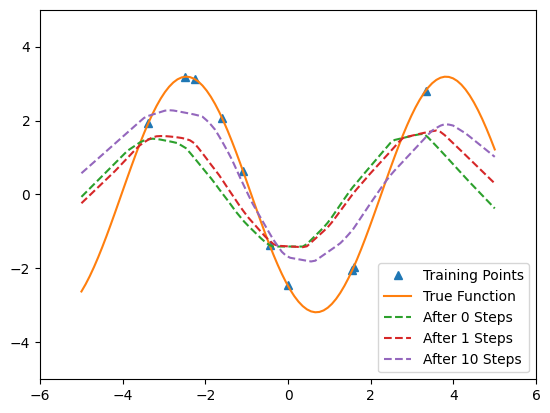

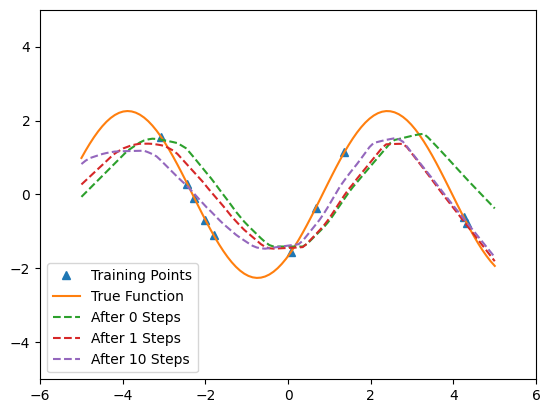

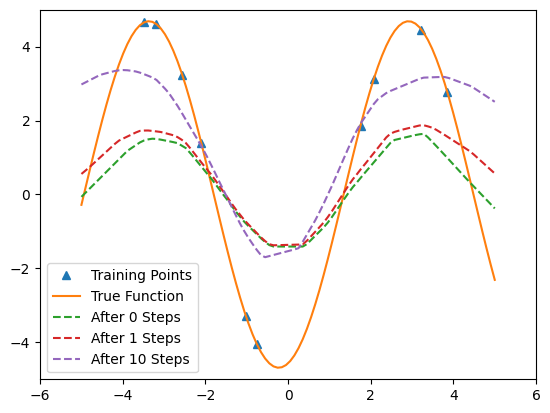

In [ ]:
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(neural_net, test_ds[index])

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

In [9]:
def train_maml(model, epochs, dataset, lr_inner=0.01, batch_size=1, log_steps=1000):
    '''Train using the MAML setup.

    The comments in this function that start with:

        Step X:

    Refer to a step described in the Algorithm 1 of the paper.

    Args:
        model: A model.
        epochs: Number of epochs used for training.
        dataset: A dataset used for training.
        lr_inner: Inner learning rate (alpha in Algorithm 1). Default value is 0.01.
        batch_size: Batch size. Default value is 1. The paper does not specify
            which value they use.
        log_steps: At every `log_steps` a log message is printed.

    Returns:
        A strong, fully-developed and trained maml.
    '''
    optimizer = keras.optimizers.Adam()

    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for _ in range(epochs):
        total_loss = 0
        losses = []
        start = time.time()
        # Step 3 and 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            x, y = np_to_tensor(t.batch())
            model.forward(x)  # run forward pass to initialize weights
            with tf.GradientTape() as test_tape:
                # test_tape.watch(model.trainable_variables)
                # Step 5
                with tf.GradientTape() as train_tape:
                    train_loss, _ = compute_loss(model, x, y)
                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                # Step 8
                test_loss, logits = compute_loss(model_copy, x, y)
            # Step 8
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            # Logs
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            losses.append(loss)

            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

#### Training MAML

It should take around 40 seconds to train for 1000 steps.

In [10]:
maml = SineModel()
train_maml(maml, 1, train_ds)

tf.Tensor(
[[-2.4302575 ]
 [ 1.36104211]
 [ 0.36783637]
 [-2.82532363]
 [ 0.68161177]
 [-0.97494961]
 [ 2.71000521]
 [-2.98153449]
 [ 1.74852567]
 [ 1.5452177 ]], shape=(10, 1), dtype=float64)


NameError: name 'copy_model' is not defined

#### Use MAML model to fit new sine wave

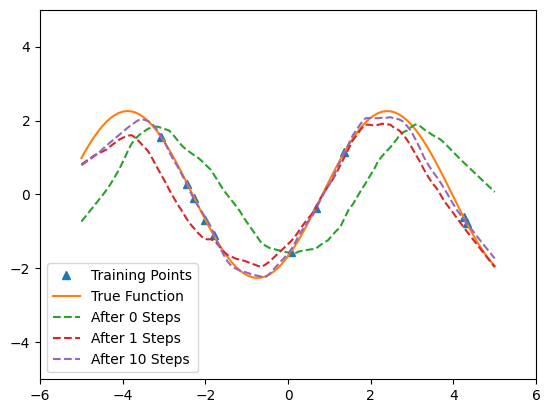

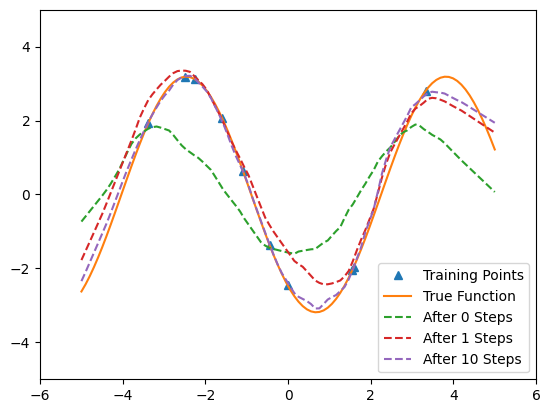

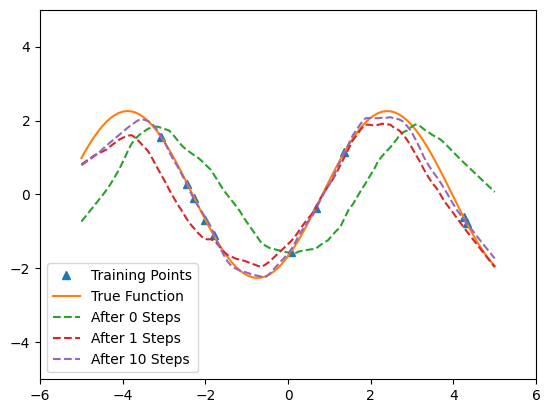

In [ ]:
for index in np.random.randint(0, len(test_ds), size=3):
    eval_sinewave_for_test(maml, test_ds[index])

### MAML vs Regular Neural Network

In [ ]:
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--'):
    '''Compare the loss of a MAML model and a neural net.

    Fits the models for a new task (new sine wave) and then plot
    the loss of both models along `num_steps` interactions.

    Args:
        maml: An already trained MAML.
        neural_net: An already trained neural net.
        num_steps: Number of steps to be logged.
        intermediate_plot: If True plots intermediate plots from
            `eval_sinewave_for_test`.
        marker: Marker used for plotting.
        linestyle: Line style used for plotting.
    '''
    if intermediate_plot:
        print('MAML')
    fit_maml = eval_sinewave_for_test(maml, sinusoid_generator, plot=intermediate_plot)
    if intermediate_plot:
        print('Neural Net')
    fit_neural_net = eval_sinewave_for_test(neural_net, sinusoid_generator, plot=intermediate_plot)

    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}

    legend = []
    for name in fit_res:
        x = []
        y = []
        for n, _, loss in fit_res[name]:
            x.append(n)
            y.append(loss)
        plt.plot(x, y, marker=marker, linestyle=linestyle)
        plt.xticks(num_steps)
        legend.append(name)
    plt.legend(legend)
    plt.show()

MAML


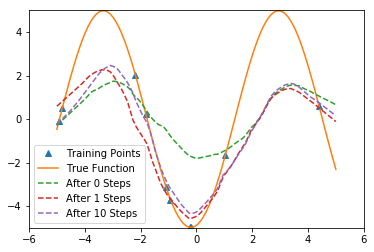

Neural Net


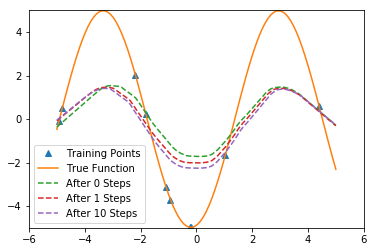

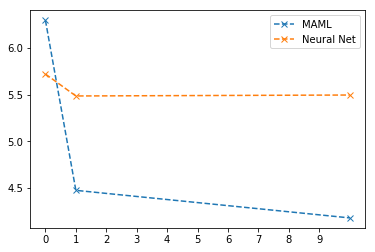

MAML


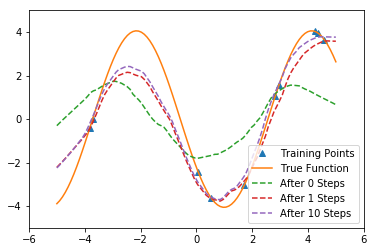

Neural Net


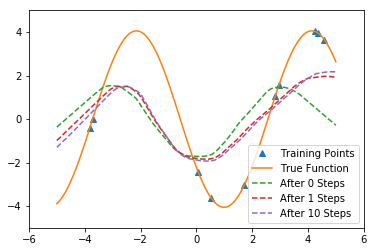

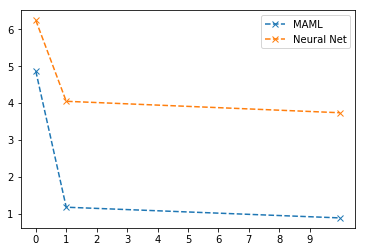

MAML


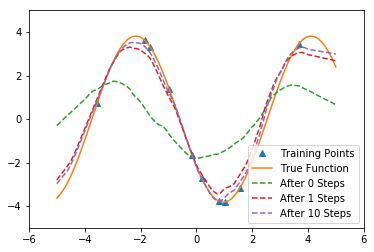

Neural Net


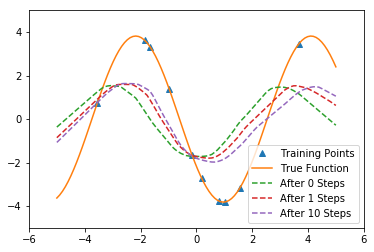

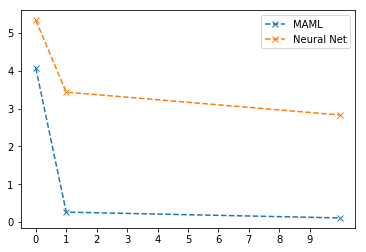

In [ ]:
for _ in range(3):
    index = np.random.choice(range(len(test_ds)))
    compare_maml_and_neural_net(maml, neural_net, test_ds[index])